# PPCA in TensorFlow Probability
This is the ZIFA method (Pierson, 2015)

First we import necessary libraries

In [1]:
import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

We create a function of the ZIFA model:

In [2]:
Root = tfd.JointDistributionCoroutine.Root
def ZIFA(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    
    # We start by generating a sigma^2
    sigma_sqrd = yield Root(tfd.Independent(
        tfd.Normal(loc=stddv_datapoints, scale=0.15, name='sigma')))
    
    # We initialize lambda here
    lamda = yield Root(tfd.Independent(
        tfd.Uniform(low=0.1, high=0.2, name='lambda')))
    
    # Then the latent data z
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=1.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))

    # For A we first define the boundaries for its uniform distribution and then A itself. The boundaries are created outside the function,
    # lower in this cell
    A = yield Root(tfd.Independent(
        tfd.Uniform(low=low_A, high=high_A, name='A')))
    
    # Here comes mu
    mu = yield Root(tfd.Independent(
        tfd.Uniform(low=2.0*tf.ones([data_dim,1]),
                 high=6.5*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    
    # Tensorflows einsum() function is used to take the products of A and the individual columns of z, which is used to obtain the means of x
    x = yield Root(tfd.Independent(tfd.Normal(
        loc=tf.einsum('ij,ki->kj',z,A)+mu,
        scale=sigma_sqrd,
        name="x"), reinterpreted_batch_ndims=2))
    
    # Bernoulli variable h is generated based on x and lambda
    h = yield Root(tfd.Independent(tfd.Bernoulli(
        probs = 1-tf.exp(tf.multiply(-lamda,tf.square(x))), name = 'h',dtype=tf.float32,)))
#     h = h_dist.sample()
    
    # Then the final points y can be generated
    y = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.multiply(h,x),
                 scale=0,
                 name="y"), reinterpreted_batch_ndims=2))
    

num_datapoints = 10000
data_dim = 3
latent_dim = 2
stddv_datapoints = 0.3

# The boundaries for the uniform distribution of A
low_A = np.float32(-0.5*np.ones([data_dim, latent_dim]))
np.fill_diagonal(low_A,0.9*stddv_datapoints)
high_A = np.float32(0.5*np.ones([data_dim, latent_dim]))
np.fill_diagonal(high_A,1.1*stddv_datapoints)

concrete_ZIFA_model = functools.partial(ZIFA,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model = tfd.JointDistributionCoroutine(concrete_ZIFA_model)

And we generate some data. Note the Zero inflation as depicted in the three histograms representing three genes.

Lambda:  tf.Tensor(0.19888413, shape=(), dtype=float32)
mu: tf.Tensor(
[[3.2047887]
 [3.1022995]
 [6.2340527]], shape=(3, 1), dtype=float32)


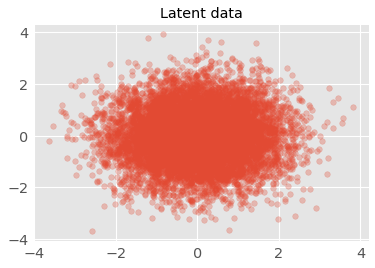

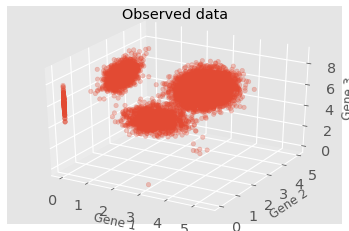

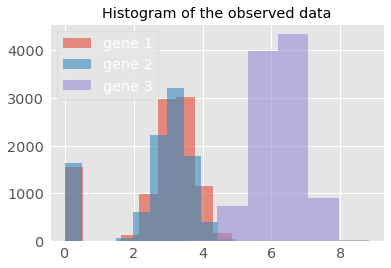

In [3]:
actual_sigma, actual_lambda, actual_z, actual_A, actual_mu, actual_x, actual_h, y_train = model.sample()
print('Lambda: ', actual_lambda)
print('mu:', actual_mu)

# print("Principal axes:")
# print(actual_w)
# print(actual_z)

plt.scatter(actual_z[0,:], actual_z[1,:], alpha=0.3)
title = plt.title('Latent data')
plt.setp(title, color='black') 
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train[0,:],y_train[1,:],y_train[2,:], alpha=0.3)
title = ax.set_title("Observed data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

plt.hist(y_train[0, :], label='gene 1', alpha=0.6)
plt.hist(y_train[1, :], label='gene 2', alpha=0.6)
plt.hist(y_train[2, :], label='gene 3', alpha=0.6)
title = plt.title('Histogram of the observed data')
plt.setp(title, color='black')
plt.legend()
plt.show()

Note: When evaluating the log probabiltiy of an event, we sometimes get 'nan'-values, which is why optimalization is not yet fully functional.

In [4]:
model.log_prob((actual_sigma, actual_lambda, actual_z, actual_A, actual_mu, actual_h, actual_x, y_train))

<tf.Tensor: id=527, shape=(3,), dtype=float32, numpy=array([nan, nan, nan], dtype=float32)>

Then we minimize the error numerically. According to Pierson (2015), $\mu$ and $A$ should be optimized first, followed by $\sigma^2$ and ending with $\lambda$. We first optimize $\mu$ by initializing it as the mean of our observed data. We then optimalize on a separate model that doesn't contain $\lambda$, followed by the complete model.

In [5]:
def ZIFA_step1(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    
    sigma_sqrd = yield Root(tfd.Independent(
        tfd.Normal(loc=stddv_datapoints, scale=0.05, name='sigma')))
    
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=1.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))

    A = yield Root(tfd.Independent(
        tfd.Uniform(low=low_A, high=high_A, name='A')))
    
    mu = yield Root(tfd.Independent(
        tfd.Uniform(low=2.5*tf.ones([data_dim,1]),
                 high=5.5*tf.ones([data_dim,1]),
                 name="mu"), reinterpreted_batch_ndims=1))
    
    y = yield tfd.Independent(tfd.Normal(
        loc=tf.einsum('ij,ki->kj',z,A)+mu,
        scale=sigma_sqrd,
        name="y"), reinterpreted_batch_ndims=2)
    
    
    
ZIFA_model_1 = functools.partial(ZIFA_step1,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model_1 = tfd.JointDistributionCoroutine(ZIFA_model_1)

Fortunately, this incomplete model is more forviging when evaluating the log probabilities. However, returned 'nan'-values do still occur.

In [6]:
model_1.log_prob((actual_sigma, actual_z, actual_A, actual_mu, y_train))

<tf.Tensor: id=631, shape=(3,), dtype=float32, numpy=array([-140639.64, -140639.64,       -inf], dtype=float32)>

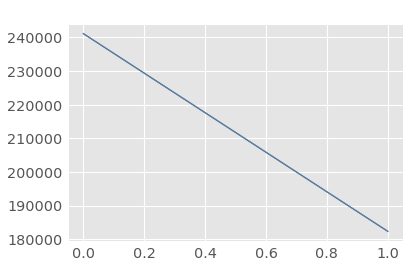

In [7]:
mu = tf.expand_dims(tf.Variable(np.float32(np.sum(y_train, axis=1)/np.sum(y_train!=0, axis=1))),1)
sigma = tf.Variable(0.3)
A_np = np.float32(np.zeros([data_dim, latent_dim]))
np.fill_diagonal(A_np,stddv_datapoints)
A = tf.Variable(A_np)
# A = tf.Variable(0.5*np.ones([data_dim, latent_dim]), dtype=tf.float32)
z = tf.Variable(np.zeros([latent_dim, num_datapoints]), dtype=tf.float32)
# A = tf.identity(actual_A)
# z = tf.identity(actual_z)

target_log_prob_fn = lambda sigma, z, A, mu: model_1.log_prob((sigma, z, A, mu, y_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(sigma, z, A, mu),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=500)
plt.plot(losses)
plt.title('Loss function over iterations')
plt.show()

Although some iterations do not return a valid loss-value as the plot demonstrates, the error is still minimized.

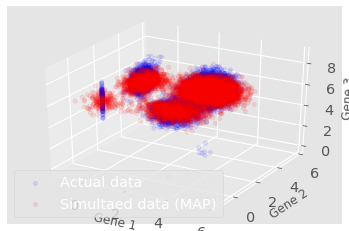

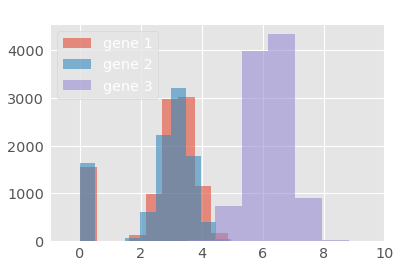

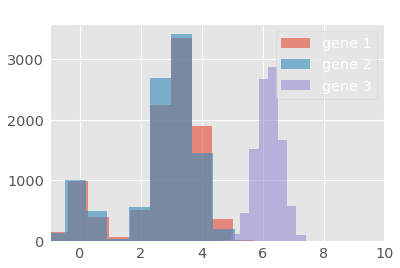

Actual mu:
 [[3.2047887]
 [3.1022995]
 [6.2340527]] 
estimated mu:
 [[3.2592826]
 [3.168526 ]
 [6.231941 ]]
Actual sigma:  0.3848196 , estimated sigma:  0.37598795
Actual A:
 [[ 0.31002453 -0.18450332]
 [-0.18599558  0.28980288]
 [ 0.4593836   0.2056272 ]] 
estimated A:
 [[ 5.822598   -1.548422  ]
 [ 1.6170615   5.8015547 ]
 [ 0.57650983 -0.32393464]]


In [8]:
_, _, _, _, y_generated_base = model_1.sample(value=(sigma, z, A, mu, None))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train[0,:],y_train[1,:],y_train[2,:], label='Actual data', color='blue', alpha=0.1)
ax.scatter(y_generated_base[0,:],y_generated_base[1,:],y_generated_base[2,:], label='Simultaed data (MAP)', color='red', alpha=0.1)
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.hist(y_train[0, :], label='gene 1', alpha=0.6)
plt.hist(y_train[1, :], label='gene 2', alpha=0.6)
plt.hist(y_train[2, :], label='gene 3', alpha=0.6)
title = plt.title('Actual data')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()

plt.hist(y_generated_base[0, :], label='gene 1', alpha=0.6)
plt.hist(y_generated_base[1, :], label='gene 2', alpha=0.6)
plt.hist(y_generated_base[2, :], label='gene 3', alpha=0.6)
title = plt.title('Simulated data (MAP)')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()
print('Actual mu:\n',actual_mu.numpy(), '\nestimated mu:\n', mu.numpy())
print('Actual sigma: ',actual_sigma.numpy(), ', estimated sigma: ', sigma.numpy())
print('Actual A:\n',actual_A.numpy(), '\nestimated A:\n', A.numpy())

The simulated data starts to look like our trainingset. Because optimalization of the zero-inflation parameter $\lambda$ has not yet been applied in the first step, the data is not yet entirely accurate. However, the modes of all distributions are relatively in place, even though the distributions are skewed towards zero, to account for the large occurence of zero-values. We can also generate data with the parameters that were just found and an initial guess of $\lambda$ of $0.1$. Allowing the zero-inflation to generate our simulated data gives more promising results.

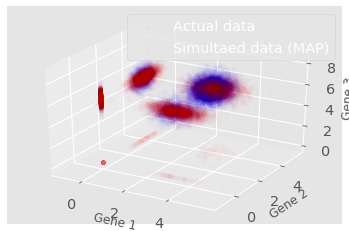

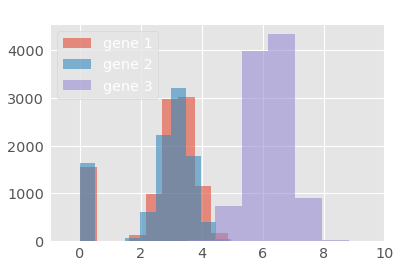

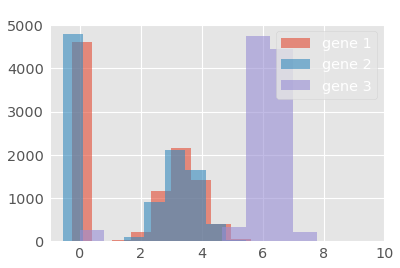

In [9]:
lamda = tf.Variable(0.1)

_, _, _, _, _, _, _, y_generated_lambda = model.sample(value=(sigma, lamda, z, A, mu, None, None, None))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train[0,:],y_train[1,:],y_train[2,:], label='Actual data', color='blue', alpha=0.01)
ax.scatter(y_generated_lambda[0,:],y_generated_lambda[1,:],y_generated_lambda[2,:], label='Simultaed data (MAP)', color='red', alpha=0.01)
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

# plt.scatter(y_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
# plt.scatter(y_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
# plt.legend()
# plt.axis([-20, 20, -20, 20])

plt.hist(y_train[0, :], label='gene 1', alpha=0.6)
plt.hist(y_train[1, :], label='gene 2', alpha=0.6)
plt.hist(y_train[2, :], label='gene 3', alpha=0.6)
title = plt.title('Actual data')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()

plt.hist(y_generated_lambda[0, :], label='gene 1', alpha=0.6)
plt.hist(y_generated_lambda[1, :], label='gene 2', alpha=0.6)
plt.hist(y_generated_lambda[2, :], label='gene 3', alpha=0.6)
title = plt.title('Simulated data (MAP)')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()


 We can now optimize our model further by evaluating the complete model with zero-inflation in our optimalization. We use the newly found parameters as our initial guess.

In [10]:
h = tf.Variable(1.0*np.ones([data_dim, num_datapoints]), dtype=tf.float32)
x = tf.identity(y_generated_lambda)

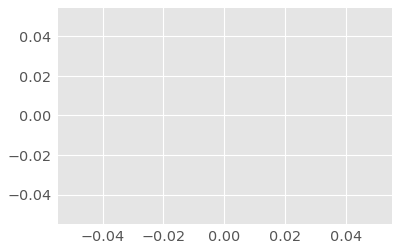

In [11]:
target_log_prob_fn = lambda sigma, lamda, z, A, mu, x, h: model.log_prob((sigma, lamda, z, A, mu, actual_x, actual_h, y_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(sigma, lamda, z, A, mu, actual_x, actual_h),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=200)
plt.plot(losses)
plt.show()

Unfortunately, something goes wrong at this step. No valid numbers are returned and the parameters take invalid values, which is why the plot doesn't work most of the time. Still we have an output, plotted below. 

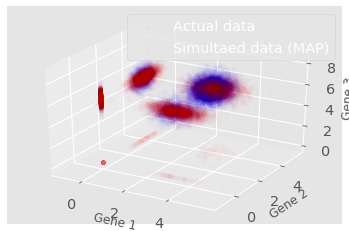

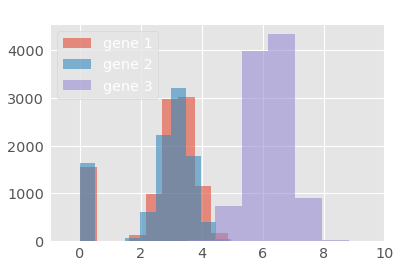

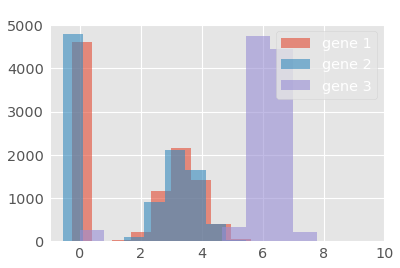

In [12]:
_, _, _, _, _, _, _, y_generated_final = model.sample(value=(sigma, lamda, z, A, mu, x, h, None))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train[0,:],y_train[1,:],y_train[2,:], label='Actual data', color='blue', alpha=0.01)
ax.scatter(y_generated_final[0,:],y_generated_final[1,:],y_generated_final[2,:], label='Simultaed data (MAP)', color='red', alpha=0.01)
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.hist(y_train[0, :], label='gene 1', alpha=0.6)
plt.hist(y_train[1, :], label='gene 2', alpha=0.6)
plt.hist(y_train[2, :], label='gene 3', alpha=0.6)
title = plt.title('Actual data')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()

plt.hist(y_generated_final[0, :], label='gene 1', alpha=0.6)
plt.hist(y_generated_final[1, :], label='gene 2', alpha=0.6)
plt.hist(y_generated_final[2, :], label='gene 3', alpha=0.6)
title = plt.title('Simulated data (MAP)')
plt.xlim((-1,10))
plt.setp(title, color='white')
plt.legend()
plt.show()


In [13]:
print('Actual Lambda: ',actual_lambda.numpy(), ', estimated Lambda: ', lamda.numpy())
print('Actual mu:\n',actual_mu.numpy(), '\nestimated mu:\n', mu.numpy())
print('Actual sigma: ',actual_sigma.numpy(), ', estimated sigma: ', sigma.numpy())
print('Actual A:\n',actual_A.numpy(), '\nestimated A:\n', A.numpy())
print('Actual z:\n',actual_z.numpy(), '\nestimated z:\n', z.numpy())

Actual Lambda:  0.19888413 , estimated Lambda:  nan
Actual mu:
 [[3.2047887]
 [3.1022995]
 [6.2340527]] 
estimated mu:
 [[3.2592826]
 [3.168526 ]
 [6.231941 ]]
Actual sigma:  0.3848196 , estimated sigma:  0.22517683
Actual A:
 [[ 0.31002453 -0.18450332]
 [-0.18599558  0.28980288]
 [ 0.4593836   0.2056272 ]] 
estimated A:
 [[ 3.362923  -3.7079628]
 [-1.0189021  4.945338 ]
 [ 7.7085724  2.5618517]]
Actual z:
 [[ 0.35213175  0.11170809 -1.5871819  ... -0.7421212  -1.1747583
   0.60759115]
 [-0.62697923  1.1798824   0.9580519  ...  1.550479    0.9255526
  -1.0860372 ]] 
estimated z:
 [[ 0.02185221  0.02815815 -0.07775708 ... -0.10072192 -0.04870611
   0.02721572]
 [-0.04628385  0.1443431   0.09958725 ...  0.02376539  0.07776896
  -0.01415216]]


Visually, the output values look very similar in both the histogram and the scatterplot. On inspection of the actual values of all parameters, we observe that $\lambda$ and $\mu$ tend to be estimated quite accurately and the value for $\sigma$ is usually not too far off either. $A$ and $z$, however, are usually found with different numbers than their actual values.

In [14]:
tf.einsum('ij,ki->kj',z,A)

<tf.Tensor: id=7587, shape=(3, 10000), dtype=float32, numpy=
array([[ 0.2451061 , -0.4405251 , -0.6307569 , ..., -0.42684123,
        -0.4521593 ,  0.14400007],
       [-0.25115454,  0.68513495,  0.57171947, ...,  0.22015364,
         0.43422052, -0.09771738],
       [ 0.04987701,  0.58684474, -0.34426832, ..., -0.7155388 ,
        -0.176222  ,  0.17353858]], dtype=float32)>

The products of $A$ and $z_i$ given vectors with values relatively close to $0$. This means that the algorithm mostly used $\mu$ to guess the position of the output-values.